In [1]:

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time
import random
import scipy.stats as stats
from scipy.sparse import *
from mainSVT import *
from visualizingData import *
import pandas as pd
import os
import ast


In [2]:
# Load the data from the specified .npz file
file = np.load("..\\..\\data_manip\\provided_data\\SIMS.npz", allow_pickle=True)

# # Extract the necessary components from the file
print(file.files)

selected_B = file['selected_B'][()]
shape = file['shape'][()]
mz_values = file['mz'][()]

ground_truth = selected_B


['selected_B', 'shape', 'mz']


In [3]:
selected_B.shape

(608400, 806)

In [4]:

selected_B = selected_B.toarray()
mask = np.where(selected_B==0,0,1)

In [5]:
DENSE, MASK = selected_B , mask


DENSE, MASK = sample_array_with_mask(DENSE,MASK,10000 )


In [6]:
import time
from scipy.sparse.linalg import svds
from scipy.linalg import norm
import numpy as np

In [7]:

def svt(data_matrix, step_size, tolerance, tau, max_iter, mask, max_rank=10):
    t = time.time()
    # Initialize k and a Y_0
    k = 1
    Y_0 = k_0_finder(tau, step_size, data_matrix*mask) * step_size * data_matrix*mask
    
    # Tracking variables
    rank_arr = []
    rel_error_s_arr = []

    # Iterative SVT
    Y = Y_0
    print(f'Y_0 maken duurde {time.time()-t} s')
    print('Starting up...')
    
    for k in range(1, max_iter + 1):
        # Compute top singular values/vectors using sparse SVD
        U, sigma, Vt = svd(Y,full_matrices=False)
        print(f'sigma = {sigma[:3]}')
        
        # Thresholding singular values
        sigma_thresh = np.maximum(sigma - tau, 0)
        rank = np.sum(sigma_thresh > 0)

        # Construct the low-rank approximation
        X = U[:, :rank] @ np.diag(sigma_thresh[:rank]) @ Vt[:rank, :]


        # Calculate relative error
        error_sampled_matrix = mask *(data_matrix - X)
        
        rel_insampling, rel_outsampling, rel_gen_err = allErrors(data_matrix, X,mask)
        r_err_stop = np.sqrt(rel_insampling/100)
        
        # Adjust step size for stability
        if r_err_stop < 1e-2:
            step_size *= 0.9
        
        # Update Y
        Y += step_size * error_sampled_matrix

        # Store metrics
        rank_arr.append(rank)
        rel_error_s_arr.append([rel_insampling, rel_outsampling, rel_gen_err])

        # Print iteration details
        print(f'Iter {k};')
        print(f'IS={rel_insampling}; OS={rel_outsampling}; GE={rel_gen_err}')
        print('Rank:', rank)
        print()

        # Check stopping conditions
        if rank > max_rank or r_err_stop < tolerance or suggested_stop(X, data_matrix, tolerance):
            break
    
    return X, rank_arr, k, rel_error_s_arr


In [8]:
DENSE.shape

(10000, 806)

In [9]:


# Parameters for SVT
step_size = 1.2
tolerance = 1e-4
tau = 5*np.sqrt(max(DENSE.shape))
max_iter = 500
max_rank = min(DENSE.shape)//10


# # Run SVT
# X, rank_arr, num_iters, rel_errors = svt(DENSE, step_size, tolerance, tau, max_iter,MASK, max_rank)
# print("Final rank:", rank_arr[-1])
# print("Number of iterations:", num_iters)


In [10]:
def optimize_tau(
    data_matrix, mask, step_size, tolerance, tau_values, max_iter, max_rank=10
):
    """
    Perform grid search to optimize tau for the SVT algorithm.
    Args:
        data_matrix (ndarray): The original dense matrix to approximate.
        mask (ndarray): Binary mask indicating observed entries.
        step_size (float): Step size for SVT updates.
        tolerance (float): Stopping criterion for relative error.
        tau_values (list or ndarray): List of tau values to evaluate.
        max_iter (int): Maximum number of iterations for SVT.
        max_rank (int): Maximum allowable rank.

    Returns:
        best_tau (float): The optimal tau value.
        best_rank (int): Rank achieved with the best tau.
        errors (list): List of (tau, rel_error) tuples.
    """
    errors = []
    best_tau = None
    best_error = float("inf")
    best_rank = None

    for tau in tau_values:
        print(f"Testing tau = {tau}")
        X, rank_arr, num_iters, rel_errors = svt(
            data_matrix, step_size, tolerance, tau, max_iter, mask, max_rank
        )

        # Use the INSAMPLING error (or any specific metric) for comparison
        rel_gen_err = rel_errors[-1][0]

        errors.append((tau, rel_gen_err))
        if rel_gen_err < best_error:
            best_error = rel_gen_err
            best_tau = tau
            best_rank = rank_arr[-1]

    return best_tau, best_rank, errors

def get_tau_range(data_matrix, scale_factor=800, num_values=10):
    """
    Generate a range of tau values for optimization.
    Args:
        data_matrix (ndarray): Original dense matrix.
        scale_factor (float): Scaling multiplier for tau.
        num_values (int): Number of tau values to generate.

    Returns:
        tau_values (ndarray): Array of tau values.
    """
    max_val = max(data_matrix.shape)
    tau_min = scale_factor * 1 * max_val
    tau_max = scale_factor * 9 * max_val
    return np.linspace(tau_min, tau_max, num_values)

def plot_tau_errors(errors):
    """
    Plot the relationship between tau values and generalization error.
    Args:
        errors (list): List of (tau, rel_error) tuples.
    """
    tau_values, rel_errors = zip(*errors)
    plt.figure(figsize=(10, 6))
    plt.plot(tau_values, rel_errors, marker="o", label="Generalization Error")
    plt.xlabel("Tau")
    plt.ylabel("Generalization Error")
    plt.title("Tau vs. Generalization Error")
    plt.legend()
    plt.grid()
    plt.show()


In [11]:
# Define tau range based on the data
tau_values = get_tau_range(DENSE, scale_factor=1e-1, num_values=9)

# Run optimization for tau
best_tau, best_rank, errors = optimize_tau(
    DENSE, MASK, step_size, tolerance, tau_values, max_iter, max_rank
)

# Output results
print("Optimal tau:", best_tau)
print("Rank achieved:", best_rank)
print("Errors:", errors)


Testing tau = 1000.0
Y_0 maken duurde 0.7574458122253418 s
Starting up...
sigma = [1245.06801748  338.91105705  239.8763426 ]
Iter 1;
IS=70.66583450721443; OS=2.379368416366314; GE=73.04520292358079
Rank: 1

sigma = [1659.82188606  488.56333339  341.40918269]
Iter 2;
IS=46.32696443317374; OS=19.216849773754493; GE=65.54381420692833
Rank: 1

sigma = [1754.54283659  601.8099624   413.90961092]
Iter 3;
IS=40.75887865367262; OS=31.28207504837612; GE=72.04095370204874
Rank: 1

sigma = [1829.86659496  700.66833345  485.73551053]
Iter 4;
IS=36.485469029803895; OS=44.15986398058172; GE=80.6453330103855
Rank: 1

sigma = [1899.22953815  788.36473707  572.72237561]
Iter 5;
IS=33.16374183699505; OS=57.77400528717749; GE=90.9377471241724
Rank: 1

sigma = [1963.17540135  867.47374329  660.52612233]
Iter 6;
IS=30.550350323592767; OS=71.6748722699565; GE=102.22522259354929
Rank: 1

sigma = [2021.87978141  940.41881252  747.20418013]
Iter 7;
IS=28.452209070798844; OS=85.54611134971306; GE=113.998320420

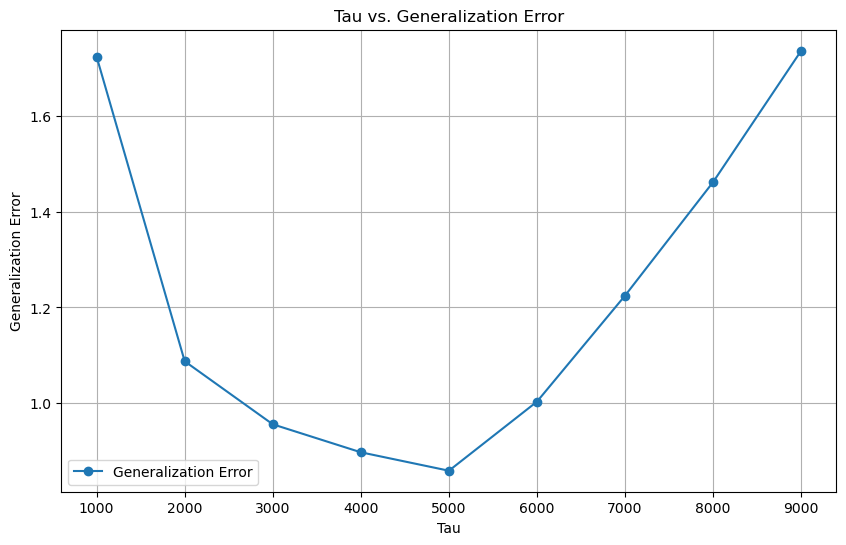

In [12]:
plot_tau_errors(errors)